In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xgboost as xgb
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_extraction import DictVectorizer
from sklearn.metrics import root_mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor, export_text

In [2]:
df = pd.read_csv("./data/car_fuel_efficiency.csv")

In [3]:
df.isnull().sum()

engine_displacement      0
num_cylinders          482
horsepower             708
vehicle_weight           0
acceleration           930
model_year               0
origin                   0
fuel_type                0
drivetrain               0
num_doors              502
fuel_efficiency_mpg      0
dtype: int64

We see that the only columns that have nulls are numeric so we can easily fill all missing values with 0s in one line

In [4]:
df = df.fillna(0.0)

In [5]:
def train_test_val_split(
    df: pd.DataFrame,
    val_frac: float = 0.2,
    test_frac: float = 0.2,
    random_state: int = 42,
    target_var: str = "y",
):
    """Perform train,validation,test split. Returns data frames of predictors and
    and arrays of targets for train,validation and test.

    Args:
        df (pd.DataFrame): The raw data
        val_frac (float, optional): The fraction of total to use for validation.
            Defaults to 0.2.
        test_frac (float, optional): The fraction of total to use for test.
            Defaults to 0.2.
        random_state (int, optional): The random state. Defaults to 42.
        target_var (str,optional): The target variable. Defaults to y.
    Returns:
        tuple: (df_train,df_val,df_test,y_train,y_val,y_test)
    """
    df_full_train, df_test = train_test_split(
        df, test_size=test_frac, random_state=random_state
    )
    df_train, df_val = train_test_split(
        df_full_train, test_size=val_frac / (1 - test_frac), random_state=random_state
    )

    y_train = df_train[target_var]
    y_val = df_val[target_var]
    y_test = df_test[target_var]

    df_train = df_train.drop(columns=[target_var])
    df_val = df_val.drop(columns=[target_var])
    df_test = df_test.drop(columns=[target_var])

    df_train = df_train.reset_index(drop=True)
    df_val = df_val.reset_index(drop=True)
    df_test = df_test.reset_index(drop=True)

    return df_train, df_val, df_test, y_train, y_val, y_test

In [6]:
df_train, df_val, df_test, y_train, y_val, y_test = train_test_val_split(
    df, random_state=1, target_var="fuel_efficiency_mpg"
)

In [ ]:
# Sanity check the split
len(df_train) / len(df), len(df_val) / len(df), len(df_test) / len(df)

(0.5999587798845837, 0.20002061005770816, 0.20002061005770816)

In [8]:
train_dicts = df_train.to_dict(orient="records")
val_dicts = df_val.to_dict(orient="records")
test_dicts = df_test.to_dict(orient="records")

dv = DictVectorizer(sparse=True)
X_train = dv.fit_transform(train_dicts)
X_val = dv.transform(val_dicts)
X_test = dv.transform(test_dicts)

# Question 1

In [9]:
dt = DecisionTreeRegressor(max_depth=1)

In [ ]:
dt.fit(X_train, y_train)

,criterion,'squared_error'
,splitter,'best'
,max_depth,1
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,None
,random_state,None
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,ccp_alpha,0.0


In [11]:
print(export_text(dt, feature_names=list(dv.get_feature_names_out())))

|--- vehicle_weight <= 3022.11
|   |--- value: [16.88]
|--- vehicle_weight >  3022.11
|   |--- value: [12.94]



We see that `vehicle_weight` is used to split the data

# Question 2

In [ ]:
rf = RandomForestRegressor(n_estimators=10, random_state=1, n_jobs=-1)

In [ ]:
rf.fit(X_train, y_train)

,n_estimators,10
,criterion,'squared_error'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,1.0
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [14]:
y_pred = rf.predict(X_val)

In [ ]:
RMSE = root_mean_squared_error(y_val, y_pred)

In [ ]:
np.round(RMSE, 2)

np.float64(0.46)

# Question 3

In [ ]:
ns = np.linspace(10, 200, 20).astype("int")

In [22]:
def n_estimator_search(ns: np.ndarray, max_depth: int | None = None) -> np.ndarray:
    rmses = []
    for n in ns:
        rf = RandomForestRegressor(
            n_estimators=n, random_state=1, max_depth=max_depth, n_jobs=-1
        )
        rf.fit(X_train, y_train)
        y_pred = rf.predict(X_val)
        RMSE = root_mean_squared_error(y_val, y_pred)
        rmses.append(RMSE)
    rmses = np.array(rmses)
    return rmses

In [23]:
rmses = n_estimator_search(ns)

Text(0, 0.5, 'val. RMSE')

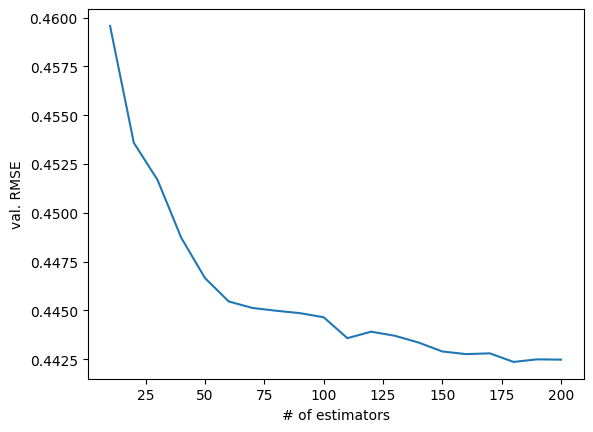

In [24]:
plt.plot(ns, rmses)
plt.xlabel("# of estimators")
plt.ylabel("val. RMSE")

In [25]:
np.round(rmses, 3)

array([0.46 , 0.454, 0.452, 0.449, 0.447, 0.445, 0.445, 0.445, 0.445,
       0.445, 0.444, 0.444, 0.444, 0.443, 0.443, 0.443, 0.443, 0.442,
       0.442, 0.442])

It's clear that out of all the presented answers only 200 works

# Question 4

In [27]:
depths = [10, 15, 20, 25]
mean_rmses = []
for depth in depths:
    res = n_estimator_search(ns, max_depth=depth)
    mean_rmses.append(np.mean(res))

mean_rmses = np.array(mean_rmses)

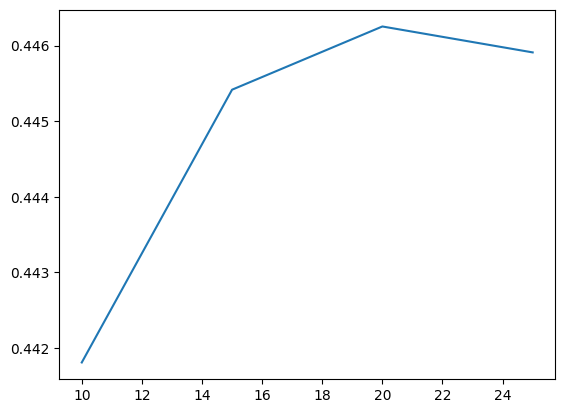

In [31]:
plt.plot(depths, mean_rmses)

So we see that `max_depth=10` gives the best mean RMSE

# Question 5

In [32]:
rf = RandomForestRegressor(n_estimators=10, max_depth=20, random_state=1, n_jobs=-1)
rf.fit(X_train, y_train)

,n_estimators,10
,criterion,'squared_error'
,max_depth,20
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,1.0
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [34]:
df_feat_importances = pd.DataFrame(
    list(zip(dv.get_feature_names_out(), rf.feature_importances_)),
    columns=["feature", "importance"],
)

In [35]:
df_feat_importances.sort_values("importance", ascending=False)

,feature,importance
13,vehicle_weight,0.959150
6,horsepower,0.015998
0,acceleration,0.011480
3,engine_displacement,0.003273
7,model_year,0.003212
8,num_cylinders,0.002343
9,num_doors,0.001635
12,origin=USA,0.000540
11,origin=Europe,0.000519
10,origin=Asia,0.000462


We see that vehicle weight is overwhelming the most important parameter. This is consistent with physical expectations

# Question 6

In [36]:
features = list(dv.get_feature_names_out())
dtrain = xgb.DMatrix(X_train, label=y_train, feature_names=features)
dval = xgb.DMatrix(X_val, label=y_val, feature_names=features)
watchlist = [(dtrain, "train"), (dval, "val")]

In [37]:
def parse_xgb_output(output):
    results = []

    for line in output.stdout.strip().split("\n"):
        it_line, train_line, val_line = line.split("\t")

        it = int(it_line.strip("[]"))
        train = float(train_line.split(":")[1])
        val = float(val_line.split(":")[1])

        results.append((it, train, val))

    columns = ["num_iter", "train_rmse", "val_rmse"]
    df_results = pd.DataFrame(results, columns=columns)
    return df_results

In [48]:
%%capture output
xgb_params = {
    "eta": 0.3,
    "max_depth": 6,
    "min_child_weight": 1,
    "objective": "reg:squarederror",
    "nthread": 8,
    "seed": 1,
    "verbosity": 1,
}
model = xgb.train(
    xgb_params, dtrain, num_boost_round=100, verbose_eval=5, evals=watchlist
)

In [49]:
df_try1 = parse_xgb_output(output)

In [50]:
df_try1["val_rmse"].iloc[-1]

np.float64(0.45018)

In [51]:
%%capture output
xgb_params.update(eta=0.1)
model = xgb.train(
    xgb_params, dtrain, num_boost_round=100, verbose_eval=5, evals=watchlist
)

In [52]:
df_try2 = parse_xgb_output(output)

In [53]:
df_try2["val_rmse"].iloc[-1]

np.float64(0.42623)

Thus $\eta=0.1$ gives a better validation RMSE